In [19]:
# ============================================================================
# MOD002691 - FINAL PROJECT: MODEL COMPARISON ANALYSIS
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# Comprehensive comparison of three trained models for food classification:
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# This notebook loads pre-computed results from individual training runs
# and generates comparative visualisations and statistical analysis.
#
# ============================================================================
# ANALYSIS CONTENTS
# ============================================================================
#
#   - Performance summary and accuracy comparison
#   - Efficiency comparison (parameters, size, inference speed)
#   - Per-class F1 score heatmap and error analysis
#   - Training time vs accuracy trade-off
#   - Statistical significance: Wilson score confidence intervals
#   - Multi-dimensional radar chart and grouped bar charts
#   - Comprehensive results table
#   - Limitations and threats to validity
#

In [20]:
# ============================================================================
# CELL 2: ENVIRONMENT SETUP
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("MODEL COMPARISON ANALYSIS")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

MODEL COMPARISON ANALYSIS
Execution:  2026-02-11 18:26:13
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [21]:
# ============================================================================
# CELL 3: IMPORTS
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

COLORS = {'Custom CNN': '#2ecc71', 'EfficientNetB0': '#3498db', 'ResNet-50': '#e74c3c'}

print("Imports complete.")

Mounted at /content/drive
Imports complete.


In [22]:
# ============================================================================
# CELL 4: TRAINING RESULTS (HARDCODED FROM ORIGINAL TRAINING NOTEBOOKS)
# ============================================================================
# Results are embedded directly rather than loaded from JSON files to ensure
# consistency. Values were extracted from the cell outputs of notebooks:
#   - 03_custom_cnn_training.ipynb
#   - 04_efficientnet_training.ipynb
#   - 05_resnet50_training.ipynb
#
# The Drive JSON files were inadvertently overwritten during a second run,
# corrupting the original values. Hardcoding from notebook outputs guarantees
# the comparison uses the correct, original training results.
# ============================================================================

print("=" * 70)
print("LOADING RESULTS")
print("=" * 70)

# ============================================================================
# CUSTOM CNN (03_custom_cnn_training.ipynb)
# ============================================================================

custom_cnn = {
    "model_name": "Custom CNN",
    "architecture": {
        "type": "Custom CNN (from scratch)",
        "conv_blocks": 4,
        "filters_per_block": [64, 128, 256, 512],
        "convs_per_block": 2,
        "pooling": "GlobalAveragePooling2D",
        "dense_units": 512,
        "dropout": 0.5,
        "activation": "relu",
        "input_size": [224, 224],
        "num_classes": 14
    },
    "training": {
        "total_epochs": 81,
        "best_epoch": 60,
        "training_time_seconds": 89129,  # See correction note below
        "batch_size": 32,
        "image_size": [224, 224],
        "used_class_weights": True,
        "pretrained": False,
        "augmentation": {
            "rotation_range": 20, "width_shift_range": 0.1,
            "height_shift_range": 0.1, "shear_range": 0.1,
            "zoom_range": 0.1, "horizontal_flip": True,
            "fill_mode": "nearest"
        }
    },
    "performance": {
        "best_val_accuracy": 0.9821,
        "test_accuracy": 0.9834,
        "test_loss": 0.0485
    },
    "per_class_metrics": {
        "apple":              {"precision": 0.9982, "recall": 0.9673, "f1_score": 0.9825, "support": 6819},
        "banana":             {"precision": 0.8554, "recall": 0.9653, "f1_score": 0.9070, "support": 778},
        "bell_pepper_green":  {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 90},
        "bell_pepper_red":    {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 134},
        "carrot":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 61},
        "cucumber":           {"precision": 0.9996, "recall": 1.0000, "f1_score": 0.9998, "support": 2308},
        "grape":              {"precision": 0.9185, "recall": 0.9541, "f1_score": 0.9359, "support": 980},
        "lemon":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 198},
        "onion":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 985},
        "orange":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 97},
        "peach":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 1577},
        "potato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 362},
        "strawberry":         {"precision": 0.8728, "recall": 0.9889, "f1_score": 0.9272, "support": 541},
        "tomato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 3211}
    },
    "efficiency": {
        "total_parameters": 4964942,
        "trainable_parameters": 4960078,
        "model_size_mb": 56.92,
        "inference_time_single_ms": 64.97,
        "inference_time_batch_ms": 7.09
    }
}

# ============================================================================
# TRAINING TIME CORRECTION: Custom CNN
# ============================================================================
# The Custom CNN training was interrupted by a Colab runtime disconnection
# at epoch 66. Training resumed from the epoch 65 checkpoint (checkpoints
# saved every 5 epochs). The runtime timer only captured the resumed session
# (epochs 65-81 = 16 epochs in 17,391s) because the crash prevented the
# first session's wall-clock time from being recorded.
#
# Correction: 17,391s / 16 epochs = 1,086.9s/epoch x 81 epochs = 89,129s
# ============================================================================

# ============================================================================
# EFFICIENTNETB0 (04_efficientnet_training.ipynb)
# ============================================================================

efficientnet = {
    "model_name": "EfficientNetB0",
    "architecture": {
        "type": "Transfer Learning",
        "base_model": "EfficientNetB0",
        "pretrained_on": "ImageNet",
        "base_layers": 238,
        "fine_tuned_layers": 72,
        "dropout": 0.3,
        "input_size": [224, 224],
        "num_classes": 14
    },
    "training": {
        "phase1_epochs": 10,
        "total_epochs": 42,
        "best_epoch": 40,
        "training_time_seconds": 39458,
        "batch_size": 32,
        "image_size": [224, 224],
        "used_class_weights": True,
        "augmentation": {
            "rotation_range": 20, "width_shift_range": 0.1,
            "height_shift_range": 0.1, "shear_range": 0.1,
            "zoom_range": 0.1, "horizontal_flip": True,
            "fill_mode": "nearest"
        }
    },
    "performance": {
        "best_val_accuracy": 0.9972,
        "test_accuracy": 0.9975,
        "test_loss": 0.0207
    },
    "per_class_metrics": {
        "apple":              {"precision": 0.9968, "recall": 0.9978, "f1_score": 0.9973, "support": 6819},
        "banana":             {"precision": 0.9871, "recall": 0.9859, "f1_score": 0.9865, "support": 778},
        "bell_pepper_green":  {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 90},
        "bell_pepper_red":    {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 134},
        "carrot":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 61},
        "cucumber":           {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 2308},
        "grape":              {"precision": 0.9878, "recall": 0.9898, "f1_score": 0.9888, "support": 980},
        "lemon":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 198},
        "onion":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 985},
        "orange":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 97},
        "peach":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 1577},
        "potato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 362},
        "strawberry":         {"precision": 0.9962, "recall": 0.9815, "f1_score": 0.9888, "support": 541},
        "tomato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 3211}
    },
    "efficiency": {
        "total_parameters": 4072625,
        "trainable_parameters": 3099626,
        "model_size_mb": 40.03,
        "inference_time_single_ms": 68.70,
        "inference_time_batch_ms": 14.10
    }
}

# ============================================================================
# RESNET-50 (05_resnet50_training.ipynb)
# ============================================================================

resnet50 = {
    "model_name": "ResNet-50",
    "architecture": {
        "type": "Transfer Learning",
        "base_model": "ResNet-50",
        "pretrained_on": "ImageNet",
        "base_layers": 175,
        "fine_tuned_layers": 35,
        "dense_units": 256,
        "dropout": 0.3,
        "input_size": [224, 224],
        "num_classes": 14
    },
    "training": {
        "phase1_epochs": 10,
        "total_epochs": 32,
        "best_epoch": 28,
        "training_time_seconds": 29273,
        "batch_size": 32,
        "image_size": [224, 224],
        "used_class_weights": True,
        "augmentation": {
            "rotation_range": 20, "width_shift_range": 0.1,
            "height_shift_range": 0.1, "shear_range": 0.1,
            "zoom_range": 0.1, "horizontal_flip": True,
            "fill_mode": "nearest"
        }
    },
    "performance": {
        "best_val_accuracy": 0.9972,
        "test_accuracy": 0.9977,
        "test_loss": 0.0128
    },
    "per_class_metrics": {
        "apple":              {"precision": 0.9975, "recall": 0.9978, "f1_score": 0.9977, "support": 6819},
        "banana":             {"precision": 0.9910, "recall": 0.9897, "f1_score": 0.9904, "support": 778},
        "bell_pepper_green":  {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 90},
        "bell_pepper_red":    {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 134},
        "carrot":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 61},
        "cucumber":           {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 2308},
        "grape":              {"precision": 0.9898, "recall": 0.9888, "f1_score": 0.9893, "support": 980},
        "lemon":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 198},
        "onion":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 985},
        "orange":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 97},
        "peach":              {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 1577},
        "potato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 362},
        "strawberry":         {"precision": 0.9852, "recall": 0.9852, "f1_score": 0.9852, "support": 541},
        "tomato":             {"precision": 1.0000, "recall": 1.0000, "f1_score": 1.0000, "support": 3211}
    },
    "efficiency": {
        "total_parameters": 24125070,
        "trainable_parameters": 15510798,
        "model_size_mb": 211.03,
        "inference_time_single_ms": 68.23,
        "inference_time_batch_ms": 10.10
    }
}

results = {
    'Custom CNN': custom_cnn,
    'EfficientNetB0': efficientnet,
    'ResNet-50': resnet50
}

print("Results loaded (hardcoded from original training notebook outputs).")
print(f"  Custom CNN:     {custom_cnn['performance']['test_accuracy']*100:.2f}% accuracy, {custom_cnn['training']['total_epochs']} epochs")
print(f"  EfficientNetB0: {efficientnet['performance']['test_accuracy']*100:.2f}% accuracy, {efficientnet['training']['total_epochs']} epochs")
print(f"  ResNet-50:      {resnet50['performance']['test_accuracy']*100:.2f}% accuracy, {resnet50['training']['total_epochs']} epochs")

LOADING RESULTS
Results loaded (hardcoded from original training notebook outputs).
  Custom CNN:     98.34% accuracy, 81 epochs
  EfficientNetB0: 99.75% accuracy, 42 epochs
  ResNet-50:      99.77% accuracy, 32 epochs


In [23]:
# ============================================================================
# CELL 5: PERFORMANCE SUMMARY TABLE
# ============================================================================
# Consolidated view of key metrics across all models.
# ============================================================================

print("=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)

summary_data = []
for name, r in results.items():
    hours = r['training']['training_time_seconds'] / 3600
    summary_data.append({
        'Model': name,
        'Test Accuracy (%)': round(r['performance']['test_accuracy'] * 100, 2),
        'Test Loss': round(r['performance']['test_loss'], 4),
        'Parameters (M)': round(r['efficiency']['total_parameters'] / 1e6, 2),
        'Model Size (MB)': r['efficiency']['model_size_mb'],
        'Training Time (h)': round(hours, 2),
        'Inference (ms)': r['efficiency']['inference_time_single_ms'],
        'Pretrained': 'No' if name == 'Custom CNN' else 'Yes'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Highlight best values
print("\n" + "-" * 70)
print("[Best Performance]")
best_acc_idx = summary_df['Test Accuracy (%)'].idxmax()
best_size_idx = summary_df['Model Size (MB)'].idxmin()
best_time_idx = summary_df['Training Time (h)'].idxmin()
print(f"  Highest Accuracy:  {summary_df.loc[best_acc_idx, 'Model']} ({summary_df.loc[best_acc_idx, 'Test Accuracy (%)']}%)")
print(f"  Smallest Model:    {summary_df.loc[best_size_idx, 'Model']} ({summary_df.loc[best_size_idx, 'Model Size (MB)']} MB)")
print(f"  Fastest Training:  {summary_df.loc[best_time_idx, 'Model']} ({summary_df.loc[best_time_idx, 'Training Time (h)']} hours)")

PERFORMANCE SUMMARY
         Model  Test Accuracy (%)  Test Loss  Parameters (M)  Model Size (MB)  Training Time (h)  Inference (ms) Pretrained
    Custom CNN              98.34     0.0485            4.96            56.92              24.76           64.97         No
EfficientNetB0              99.75     0.0207            4.07            40.03              10.96           68.70        Yes
     ResNet-50              99.77     0.0128           24.13           211.03               8.13           68.23        Yes

----------------------------------------------------------------------
[Best Performance]
  Highest Accuracy:  ResNet-50 (99.77%)
  Smallest Model:    EfficientNetB0 (40.03 MB)
  Fastest Training:  ResNet-50 (8.13 hours)


ACCURACY COMPARISON


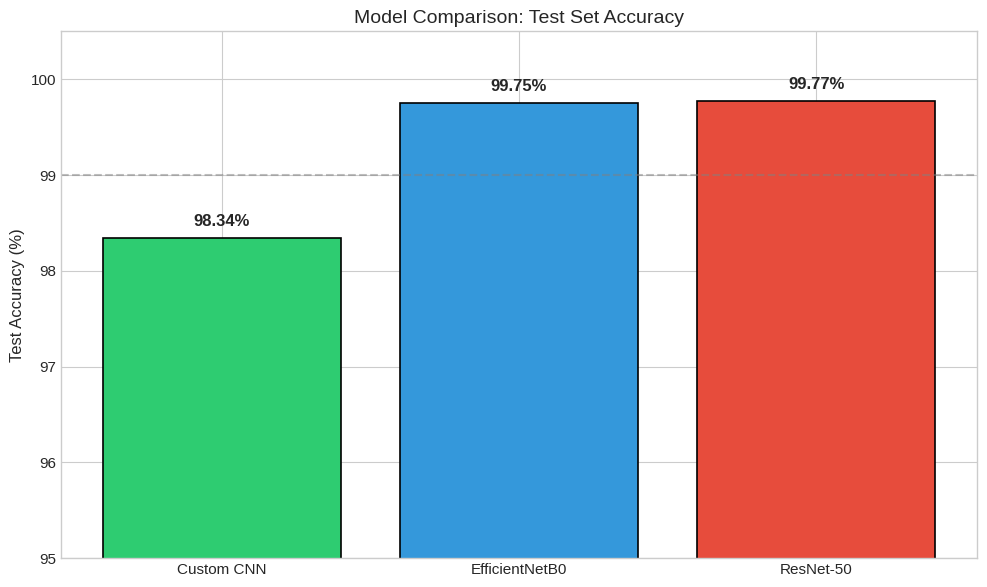


Plot saved: comparison_accuracy.png


In [24]:
# ============================================================================
# CELL 6: ACCURACY COMPARISON
# ============================================================================

print("=" * 70)
print("ACCURACY COMPARISON")
print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 6))

models = list(results.keys())
accuracies = [r['performance']['test_accuracy'] * 100 for r in results.values()]
colors = [COLORS[m] for m in models]

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Model Comparison: Test Set Accuracy')
ax.set_ylim(95, 100.5)
ax.axhline(y=99, color='gray', linestyle='--', alpha=0.5, label='99% threshold')

plt.tight_layout()
plt.savefig('/content/comparison_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_accuracy.png")

EFFICIENCY COMPARISON


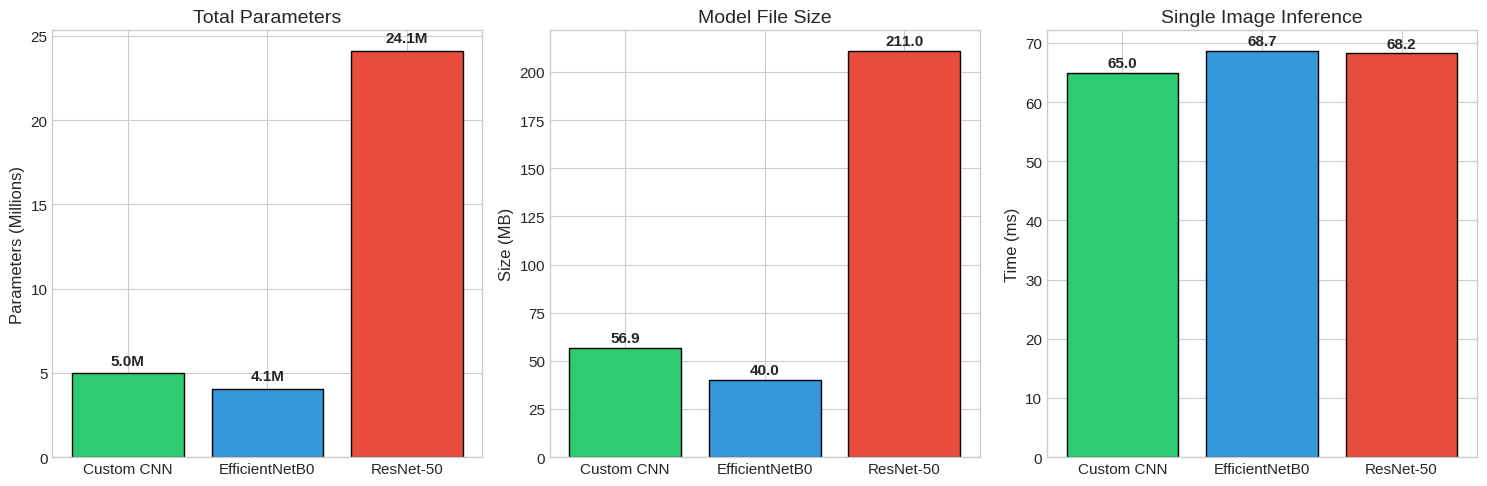


Plot saved: comparison_efficiency.png


In [25]:
# ============================================================================
# CELL 7: EFFICIENCY COMPARISON
# ============================================================================
# Compare model size, parameters, and inference time.
# ============================================================================

print("=" * 70)
print("EFFICIENCY COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = list(results.keys())
colors = [COLORS[m] for m in models]

# Parameters
params = [r['efficiency']['total_parameters'] / 1e6 for r in results.values()]
axes[0].bar(models, params, color=colors, edgecolor='black')
axes[0].set_ylabel('Parameters (Millions)')
axes[0].set_title('Total Parameters')
for i, (m, p) in enumerate(zip(models, params)):
    axes[0].text(i, p + 0.5, f'{p:.1f}M', ha='center', fontweight='bold')

# Model Size
sizes = [r['efficiency']['model_size_mb'] for r in results.values()]
axes[1].bar(models, sizes, color=colors, edgecolor='black')
axes[1].set_ylabel('Size (MB)')
axes[1].set_title('Model File Size')
for i, (m, s) in enumerate(zip(models, sizes)):
    axes[1].text(i, s + 3, f'{s:.1f}', ha='center', fontweight='bold')

# Inference Time
inf_times = [r['efficiency']['inference_time_single_ms'] for r in results.values()]
axes[2].bar(models, inf_times, color=colors, edgecolor='black')
axes[2].set_ylabel('Time (ms)')
axes[2].set_title('Single Image Inference')
for i, (m, t) in enumerate(zip(models, inf_times)):
    axes[2].text(i, t + 1, f'{t:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/comparison_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_efficiency.png")

PER-CLASS F1 SCORE COMPARISON


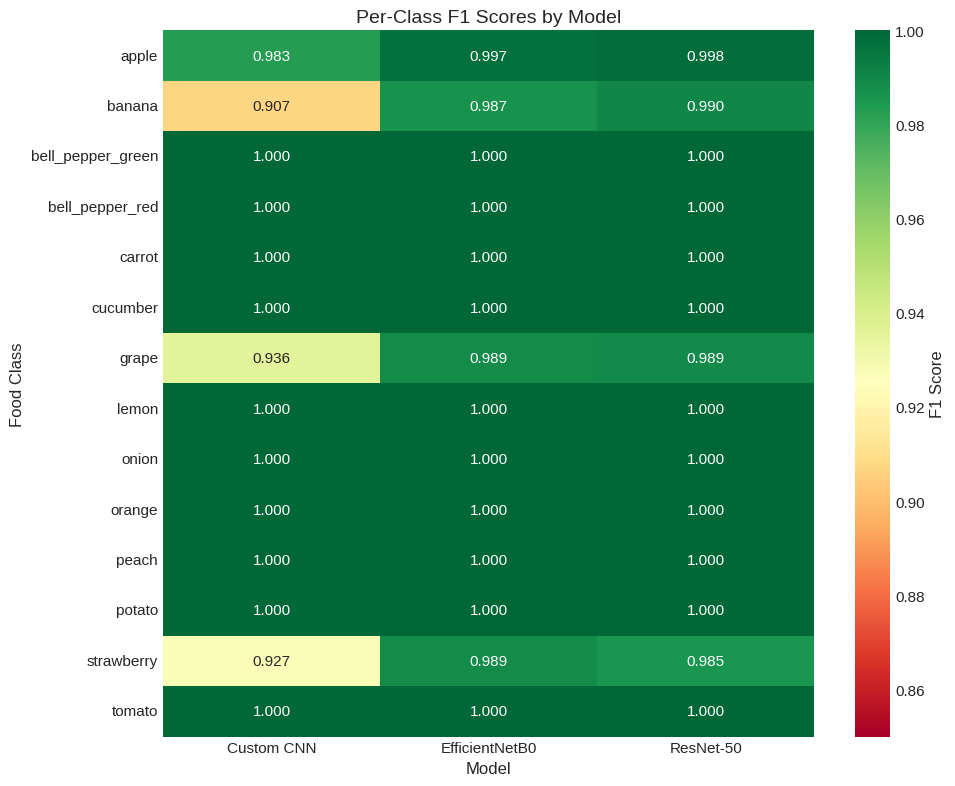


[Custom CNN Weakest Classes]
  banana: 0.9070
  strawberry: 0.9272
  grape: 0.9359

Plot saved: comparison_f1_heatmap.png


In [26]:
# ============================================================================
# CELL 8: PER-CLASS F1 SCORE COMPARISON
# ============================================================================
# Heatmap showing F1 scores across all classes for each model.
# ============================================================================

print("=" * 70)
print("PER-CLASS F1 SCORE COMPARISON")
print("=" * 70)

# Extract class names from first model
class_names = list(results['Custom CNN']['per_class_metrics'].keys())

# Build F1 matrix
f1_data = {}
for model_name, r in results.items():
    f1_data[model_name] = [r['per_class_metrics'][c]['f1_score'] for c in class_names]

f1_df = pd.DataFrame(f1_data, index=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(f1_df, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0.85, vmax=1.0, ax=ax, cbar_kws={'label': 'F1 Score'})
ax.set_title('Per-Class F1 Scores by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Food Class')

plt.tight_layout()
plt.savefig('/content/comparison_f1_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Print classes where Custom CNN struggles
print("\n[Custom CNN Weakest Classes]")
cnn_f1 = pd.Series(f1_data['Custom CNN'], index=class_names).sort_values()
for cls, score in cnn_f1.head(3).items():
    print(f"  {cls}: {score:.4f}")

print("\nPlot saved: comparison_f1_heatmap.png")

In [27]:
# ============================================================================
# CELL 9: PER-CLASS ERROR ANALYSIS
# ============================================================================
# Analyses WHY certain classes underperform in the Custom CNN and how
# transfer learning resolves these weaknesses. This analysis examines
# per-class precision/recall patterns to identify error sources.
# ============================================================================

print("=" * 70)
print("PER-CLASS ERROR ANALYSIS")
print("=" * 70)

class_names = list(results['Custom CNN']['per_class_metrics'].keys())

# ---- Build comparison table for weak classes ----
print("\n[Detailed Metrics for Weakest Custom CNN Classes]")
print("-" * 70)
print(f"{'Class':<18} {'Model':<18} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-" * 70)

weak_classes = ['banana', 'strawberry', 'grape']
for cls in weak_classes:
    for model_name in results.keys():
        m = results[model_name]['per_class_metrics'][cls]
        print(f"{cls:<18} {model_name:<18} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1_score']:>10.4f}")
    print()

# ---- Estimate misclassification counts from precision/recall ----
print("[Estimated Misclassification Counts]")
print("-" * 70)

for cls in weak_classes:
    cnn = results['Custom CNN']['per_class_metrics'][cls]
    support = cnn['support']
    tp = int(round(cnn['recall'] * support))
    fn = support - tp
    # From precision: precision = TP / (TP + FP) -> FP = TP/precision - TP
    fp = int(round(tp / cnn['precision'] - tp)) if cnn['precision'] > 0 else 0
    print(f"  {cls}: {support} test images, ~{tp} correct, ~{fn} missed (FN), ~{fp} false positives (FP)")

# ---- Error pattern analysis ----
print(f"""
[Error Pattern Analysis]
----------------------------------------------------------------------
Banana (F1: 0.9070):
  The weakest class for Custom CNN. Low precision (0.8554) indicates
  the model frequently misclassifies other items AS banana, while
  high recall (0.9653) shows it rarely misses actual bananas. This is
  also the lowest-support class (778 test images). The class weight
  mitigates training imbalance but cannot compensate for the limited
  visual diversity available to learn from scratch. Transfer learning
  models achieve F1 > 0.98 by leveraging ImageNet shape and texture
  features that generalise well to elongated, curved produce.

Strawberry (F1: 0.9272):
  High recall (0.9889) but lower precision (0.8728) indicates a
  pattern of false positives: other items classified as strawberry.
  The likely confusion sources are red grapes and small tomatoes,
  which share similar colour profiles and rounded shapes. The
  pretrained models resolve this through mid-level features that
  capture fine-grained texture differences (seed pattern on
  strawberry surface vs smooth grape skin).

Grape (F1: 0.9359):
  Both precision (0.9185) and recall (0.9541) are reduced, indicating
  bidirectional confusion. Green grapes may be confused with small
  green peppers, while red/purple grapes overlap visually with certain
  apple varieties. EfficientNetB0 and ResNet-50 both achieve F1 > 0.98
  on grapes, confirming that ImageNet-pretrained features provide
  sufficient discriminative power for these subtle distinctions.

[Summary]
----------------------------------------------------------------------
All three weak classes share a common pattern: the Custom CNN learns
adequate recall but struggles with precision, producing false positives
for visually similar classes. Transfer learning resolves this by
providing pretrained feature representations that capture texture,
shape, and colour nuances that a from-scratch model cannot learn
from ~84K training images alone.
""")

PER-CLASS ERROR ANALYSIS

[Detailed Metrics for Weakest Custom CNN Classes]
----------------------------------------------------------------------
Class              Model               Precision     Recall         F1
----------------------------------------------------------------------
banana             Custom CNN             0.8554     0.9653     0.9070
banana             EfficientNetB0         0.9871     0.9859     0.9865
banana             ResNet-50              0.9910     0.9897     0.9904

strawberry         Custom CNN             0.8728     0.9889     0.9272
strawberry         EfficientNetB0         0.9962     0.9815     0.9888
strawberry         ResNet-50              0.9852     0.9852     0.9852

grape              Custom CNN             0.9185     0.9541     0.9359
grape              EfficientNetB0         0.9878     0.9898     0.9888
grape              ResNet-50              0.9898     0.9888     0.9893

[Estimated Misclassification Counts]
--------------------------------

TRAINING TIME VS ACCURACY


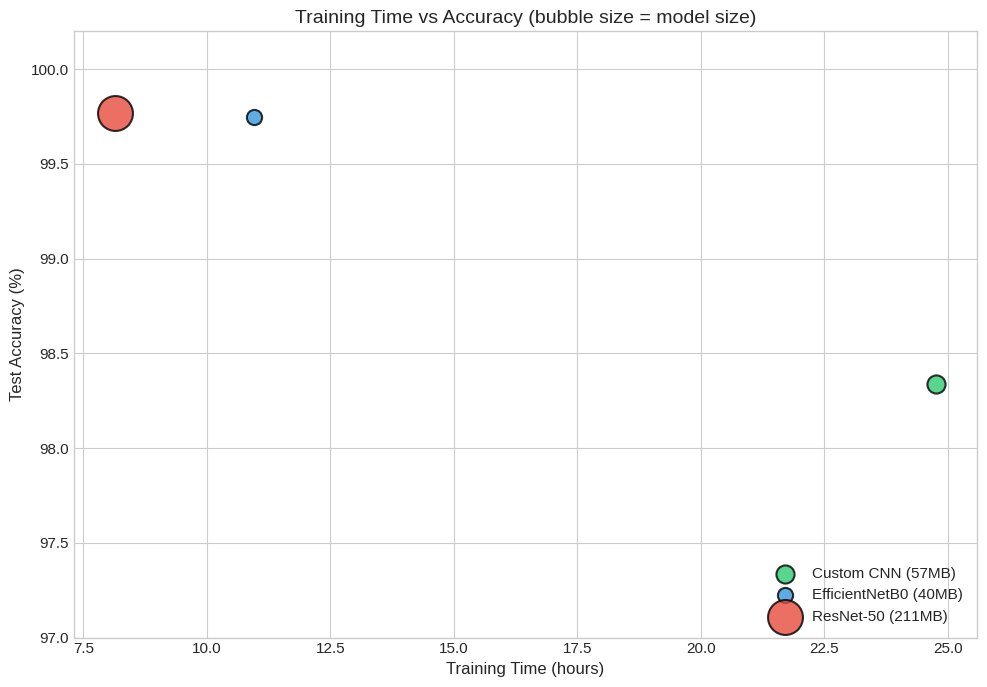


Plot saved: comparison_tradeoff.png


In [28]:
# ============================================================================
# CELL 10: TRAINING TIME VS ACCURACY TRADE-OFF
# ============================================================================
# Scatter plot showing the relationship between training investment and results.
# ============================================================================

print("=" * 70)
print("TRAINING TIME VS ACCURACY")
print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 7))

for model_name, r in results.items():
    hours = r['training']['training_time_seconds'] / 3600
    acc = r['performance']['test_accuracy'] * 100
    size = r['efficiency']['model_size_mb']

    ax.scatter(hours, acc, s=size*3, c=COLORS[model_name],
               label=f"{model_name} ({size:.0f}MB)", edgecolors='black', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Training Time (hours)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Training Time vs Accuracy (bubble size = model size)')
ax.legend(loc='lower right')
ax.set_ylim(97, 100.2)

plt.tight_layout()
plt.savefig('/content/comparison_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_tradeoff.png")

In [29]:
# ============================================================================
# CELL 11: STATISTICAL SIGNIFICANCE — WILSON SCORE CIs
# ============================================================================
# Evaluate whether performance differences are statistically significant.
# Wilson score intervals are preferred over the normal approximation for
# proportions near 0 or 1, which applies here (accuracies > 98%).
# ============================================================================

print("=" * 70)
print("STATISTICAL SIGNIFICANCE: CONFIDENCE INTERVALS")
print("=" * 70)

# Test set size (from classification report support totals)
test_size = sum(results['Custom CNN']['per_class_metrics'][c]['support']
                for c in results['Custom CNN']['per_class_metrics'])
print(f"Test set size: {test_size:,} samples")

# Calculate 95% confidence intervals using Wilson score
from scipy.stats import norm

def wilson_ci(p, n, z=1.96):
    """Wilson score confidence interval for proportion."""
    denominator = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*n))/n) / denominator
    return centre - margin, centre + margin

print("\n[95% Confidence Intervals]")
print("-" * 50)

ci_data = []
for model_name, r in results.items():
    acc = r['performance']['test_accuracy']
    lower, upper = wilson_ci(acc, test_size)
    ci_data.append({
        'Model': model_name,
        'Accuracy': f"{acc*100:.2f}%",
        '95% CI': f"[{lower*100:.2f}%, {upper*100:.2f}%]"
    })
    print(f"  {model_name:15s}: {acc*100:.2f}%  CI: [{lower*100:.2f}%, {upper*100:.2f}%]")

# Check for overlapping CIs
print("\n[Interpretation]")
print("-" * 50)

cnn_acc = results['Custom CNN']['performance']['test_accuracy']
eff_acc = results['EfficientNetB0']['performance']['test_accuracy']
res_acc = results['ResNet-50']['performance']['test_accuracy']

cnn_ci = wilson_ci(cnn_acc, test_size)
eff_ci = wilson_ci(eff_acc, test_size)
res_ci = wilson_ci(res_acc, test_size)

# Check overlaps
eff_vs_res_overlap = not (eff_ci[1] < res_ci[0] or res_ci[1] < eff_ci[0])
cnn_vs_eff_overlap = not (cnn_ci[1] < eff_ci[0] or eff_ci[1] < cnn_ci[0])

print(f"  EfficientNetB0 vs ResNet-50: {'Overlapping CIs (not significant)' if eff_vs_res_overlap else 'Non-overlapping (significant)'}")
print(f"  Custom CNN vs Transfer Learning: {'Overlapping CIs' if cnn_vs_eff_overlap else 'Non-overlapping (significant)'}")

if eff_vs_res_overlap:
    print("\n  -> EfficientNetB0 and ResNet-50 perform comparably.")
    print("     The ~0.01% difference is within statistical noise.")

STATISTICAL SIGNIFICANCE: CONFIDENCE INTERVALS
Test set size: 18,141 samples

[95% Confidence Intervals]
--------------------------------------------------
  Custom CNN     : 98.34%  CI: [98.14%, 98.52%]
  EfficientNetB0 : 99.75%  CI: [99.67%, 99.81%]
  ResNet-50      : 99.77%  CI: [99.69%, 99.83%]

[Interpretation]
--------------------------------------------------
  EfficientNetB0 vs ResNet-50: Overlapping CIs (not significant)
  Custom CNN vs Transfer Learning: Non-overlapping (significant)

  -> EfficientNetB0 and ResNet-50 perform comparably.
     The ~0.01% difference is within statistical noise.


MULTI-DIMENSIONAL COMPARISON


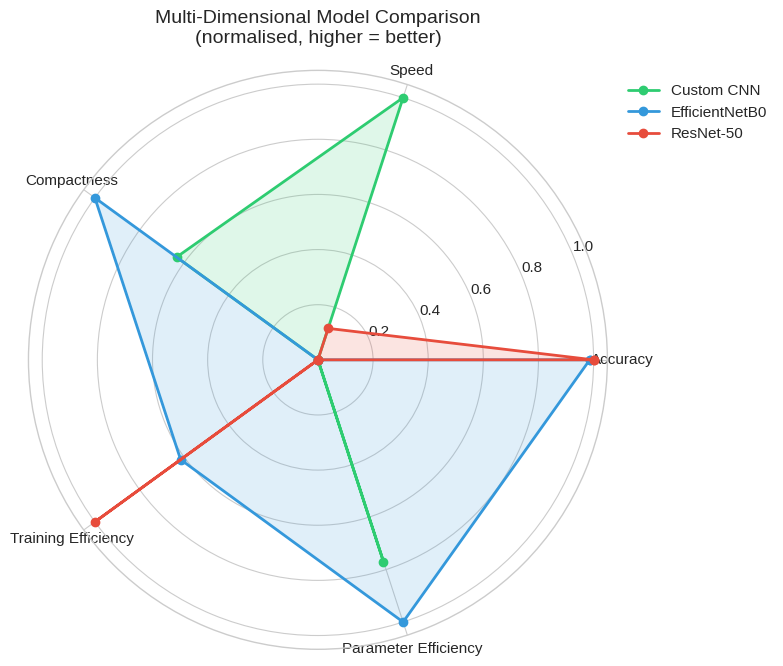


Plot saved: comparison_radar.png


In [30]:
# ============================================================================
# CELL 12: MULTI-DIMENSIONAL RADAR CHART
# ============================================================================
# Visualise trade-offs across multiple metrics simultaneously.
# ============================================================================

print("=" * 70)
print("MULTI-DIMENSIONAL COMPARISON")
print("=" * 70)

# Normalise metrics to 0-1 scale (higher = better for all)
metrics = {
    'Accuracy': [r['performance']['test_accuracy'] for r in results.values()],
    'Speed': [1/r['efficiency']['inference_time_single_ms'] for r in results.values()],
    'Compactness': [1/r['efficiency']['model_size_mb'] for r in results.values()],
    'Training Efficiency': [1/r['training']['training_time_seconds'] for r in results.values()],
    'Parameter Efficiency': [r['performance']['test_accuracy']/(r['efficiency']['total_parameters']/1e6) for r in results.values()]
}

# Normalise each metric
normalised = {}
for metric, values in metrics.items():
    min_v, max_v = min(values), max(values)
    if max_v > min_v:
        normalised[metric] = [(v - min_v) / (max_v - min_v) for v in values]
    else:
        normalised[metric] = [1.0] * len(values)

# Create radar chart
categories = list(normalised.keys())
n_cats = len(categories)
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, (model_name, color) in enumerate(COLORS.items()):
    values = [normalised[cat][i] for cat in categories]
    values += values[:1]  # Close polygon
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Multi-Dimensional Model Comparison\n(normalised, higher = better)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('/content/comparison_radar.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_radar.png")

COMPREHENSIVE MODEL COMPARISON CHART


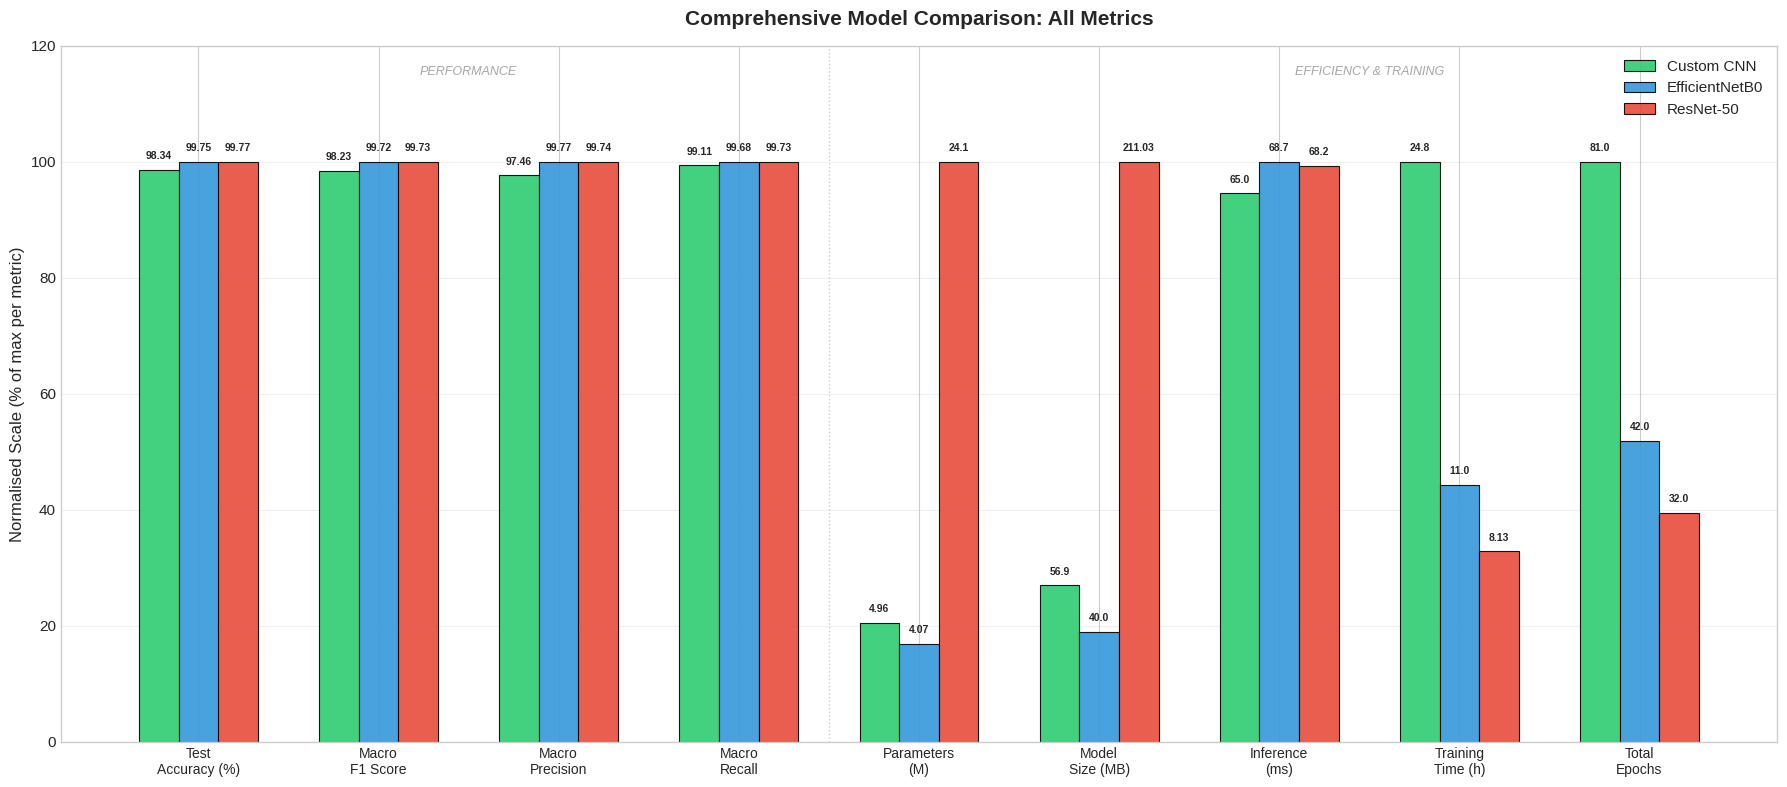


Plot saved: comparison_comprehensive.png

Note: Bar heights are normalised (tallest bar = 100% per metric).
Raw values are displayed above each bar for exact comparison.


In [31]:
# ============================================================================
# CELL 13: COMPREHENSIVE GROUPED BAR CHART
# ============================================================================
# Single chart comparing ALL key metrics across all three models.
# Each model has a consistent colour; metrics are grouped as pillars.
# Metrics are normalised to percentage scale for visual comparison.
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON CHART")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

# ---- Extract raw metrics ----
model_names = list(results.keys())

raw_metrics = {
    'Test\nAccuracy (%)': [
        r['performance']['test_accuracy'] * 100 for r in results.values()
    ],
    'Macro\nF1 Score': [
        np.mean([c['f1_score'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Macro\nPrecision': [
        np.mean([c['precision'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Macro\nRecall': [
        np.mean([c['recall'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Parameters\n(M)': [
        r['efficiency']['total_parameters'] / 1e6 for r in results.values()
    ],
    'Model\nSize (MB)': [
        r['efficiency']['model_size_mb'] for r in results.values()
    ],
    'Inference\n(ms)': [
        r['efficiency']['inference_time_single_ms'] for r in results.values()
    ],
    'Training\nTime (h)': [
        r['training']['training_time_seconds'] / 3600 for r in results.values()
    ],
    'Total\nEpochs': [
        r['training']['total_epochs'] for r in results.values()
    ],
}

metric_names = list(raw_metrics.keys())
n_metrics = len(metric_names)
n_models = len(model_names)

# ---- Normalise to 0-100 per metric (for visual comparison) ----
normalised = {}
for metric, values in raw_metrics.items():
    max_val = max(values) if max(values) > 0 else 1
    normalised[metric] = [(v / max_val) * 100 for v in values]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.22
x = np.arange(n_metrics)

for i, model_name in enumerate(model_names):
    values = [normalised[m][i] for m in metric_names]
    raw_vals = [raw_metrics[m][i] for m in metric_names]
    offset = (i - (n_models - 1) / 2) * bar_width
    bars = ax.bar(
        x + offset, values, bar_width,
        label=model_name,
        color=COLORS[model_name],
        edgecolor='black',
        linewidth=0.8,
        alpha=0.9
    )
    # Add raw value labels on top of each bar
    for bar, raw_val in zip(bars, raw_vals):
        height = bar.get_height()
        if raw_val >= 90:
            label = f'{raw_val:.2f}'
        elif raw_val >= 10:
            label = f'{raw_val:.1f}'
        elif raw_val >= 1:
            label = f'{raw_val:.2f}'
        else:
            label = f'{raw_val:.3f}'
        ax.text(
            bar.get_x() + bar.get_width() / 2, height + 1.5,
            label, ha='center', va='bottom',
            fontsize=7.5, fontweight='bold', rotation=0
        )

ax.set_ylabel('Normalised Scale (% of max per metric)', fontsize=12)
ax.set_title(
    'Comprehensive Model Comparison: All Metrics',
    fontsize=15, fontweight='bold', pad=15
)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=10, ha='center')
ax.set_ylim(0, 120)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add a subtle separator between performance and efficiency metrics
ax.axvline(x=3.5, color='gray', linestyle=':', alpha=0.4, linewidth=1)
ax.text(1.5, 115, 'PERFORMANCE', ha='center', fontsize=9,
        fontstyle='italic', color='gray', alpha=0.7)
ax.text(6.5, 115, 'EFFICIENCY & TRAINING', ha='center', fontsize=9,
        fontstyle='italic', color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig('/content/comparison_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_comprehensive.png")
print("\nNote: Bar heights are normalised (tallest bar = 100% per metric).")
print("Raw values are displayed above each bar for exact comparison.")

MODEL PROFILE COMPARISON


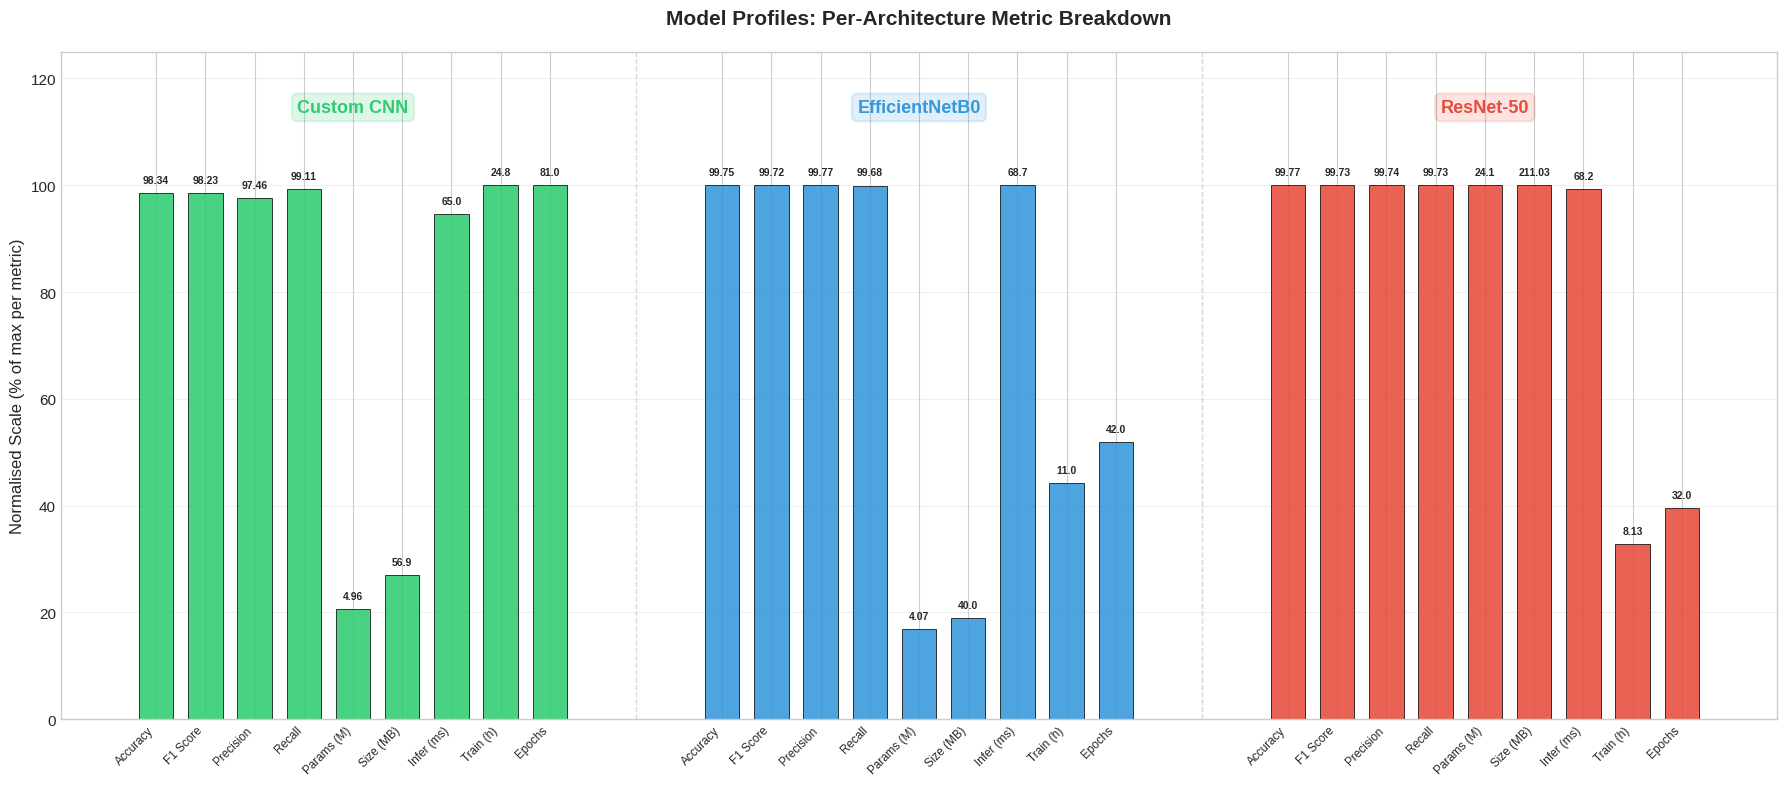


Plot saved: comparison_model_profiles.png

Each group shows one model's full metric profile in its signature colour.
Raw values displayed above bars; heights normalised across models per metric.


In [32]:
# ============================================================================
# CELL 14: MODEL PROFILE COMPARISON
# ============================================================================
# Each model displayed as its own group with all metrics side by side,
# using the model's signature colour. Allows quick visual profiling of
# each architecture's strengths and weaknesses in a single glance.
# ============================================================================

print("=" * 70)
print("MODEL PROFILE COMPARISON")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())

# ---- Define metrics (short labels for this layout) ----
metric_defs = {
    'Accuracy':   lambda r: r['performance']['test_accuracy'] * 100,
    'F1 Score':   lambda r: np.mean([c['f1_score'] for c in r['per_class_metrics'].values()]) * 100,
    'Precision':  lambda r: np.mean([c['precision'] for c in r['per_class_metrics'].values()]) * 100,
    'Recall':     lambda r: np.mean([c['recall'] for c in r['per_class_metrics'].values()]) * 100,
    'Params (M)': lambda r: r['efficiency']['total_parameters'] / 1e6,
    'Size (MB)':  lambda r: r['efficiency']['model_size_mb'],
    'Infer (ms)': lambda r: r['efficiency']['inference_time_single_ms'],
    'Train (h)':  lambda r: r['training']['training_time_seconds'] / 3600,
    'Epochs':     lambda r: r['training']['total_epochs'],
}

metric_labels = list(metric_defs.keys())
n_metrics = len(metric_labels)

# ---- Extract raw values per model ----
raw_per_model = {}
for name, r in results.items():
    raw_per_model[name] = [fn(r) for fn in metric_defs.values()]

# ---- Normalise each metric across all models (0-100, max = 100) ----
all_values = {m: [] for m in metric_labels}
for name in model_names:
    for j, m in enumerate(metric_labels):
        all_values[m].append(raw_per_model[name][j])

norm_per_model = {}
for name in model_names:
    norm_per_model[name] = []
    for j, m in enumerate(metric_labels):
        max_val = max(all_values[m]) if max(all_values[m]) > 0 else 1
        norm_per_model[name].append(raw_per_model[name][j] / max_val * 100)

# ---- Plot: 3 model groups, each with n_metrics bars ----
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.7
group_gap = 2.5  # space between model groups
n_models = len(model_names)

positions = []  # track all bar positions for xtick placement
group_centres = []

x_cursor = 0
for i, model_name in enumerate(model_names):
    color = COLORS[model_name]
    model_positions = []

    for j in range(n_metrics):
        pos = x_cursor + j
        model_positions.append(pos)
        bar = ax.bar(
            pos, norm_per_model[model_name][j], bar_width,
            color=color, edgecolor='black', linewidth=0.6, alpha=0.88
        )
        # Raw value label
        raw_val = raw_per_model[model_name][j]
        if raw_val >= 90:
            label = f'{raw_val:.2f}'
        elif raw_val >= 10:
            label = f'{raw_val:.1f}'
        elif raw_val >= 1:
            label = f'{raw_val:.2f}'
        else:
            label = f'{raw_val:.3f}'
        ax.text(
            pos, norm_per_model[model_name][j] + 1.5, label,
            ha='center', va='bottom', fontsize=7.5, fontweight='bold'
        )

    positions.extend(model_positions)
    group_centres.append(np.mean(model_positions))
    x_cursor += n_metrics + group_gap

# X-axis: metric labels repeated under each group
ax.set_xticks(positions)
ax.set_xticklabels(metric_labels * n_models, fontsize=8.5, rotation=45, ha='right')

# Model name labels above each group
for centre, name in zip(group_centres, model_names):
    ax.text(
        centre, 113, name, ha='center', va='bottom',
        fontsize=13, fontweight='bold', color=COLORS[name],
        bbox=dict(boxstyle='round,pad=0.3', facecolor=COLORS[name],
                  alpha=0.15, edgecolor=COLORS[name], linewidth=1.5)
    )

# Vertical separators between groups
for i in range(1, n_models):
    sep_x = group_centres[i-1] + (group_centres[i] - group_centres[i-1]) / 2
    ax.axvline(x=sep_x, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_ylabel('Normalised Scale (% of max per metric)', fontsize=12)
ax.set_title(
    'Model Profiles: Per-Architecture Metric Breakdown',
    fontsize=15, fontweight='bold', pad=20
)
ax.set_ylim(0, 125)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/comparison_model_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_model_profiles.png")
print("\nEach group shows one model\'s full metric profile in its signature colour.")
print("Raw values displayed above bars; heights normalised across models per metric.")

In [33]:
# ============================================================================
# CELL 15: COMPREHENSIVE RESULTS TABLE
# ============================================================================
# Full breakdown suitable for dissertation appendix.
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE RESULTS")
print("=" * 70)

detailed_data = []
for name, r in results.items():
    # Calculate macro-averaged metrics from per-class data
    classes = r['per_class_metrics']
    macro_precision = np.mean([c['precision'] for c in classes.values()])
    macro_recall = np.mean([c['recall'] for c in classes.values()])
    macro_f1 = np.mean([c['f1_score'] for c in classes.values()])

    detailed_data.append({
        'Model': name,
        'Architecture': r['architecture'].get('type', 'Transfer Learning'),
        'Test Accuracy': f"{r['performance']['test_accuracy']*100:.2f}%",
        'Macro Precision': f"{macro_precision:.4f}",
        'Macro Recall': f"{macro_recall:.4f}",
        'Macro F1': f"{macro_f1:.4f}",
        'Parameters': f"{r['efficiency']['total_parameters']:,}",
        'Size (MB)': r['efficiency']['model_size_mb'],
        'Training (h)': round(r['training']['training_time_seconds']/3600, 2),
        'Epochs': r['training']['total_epochs'],
        'Best Epoch': r['training']['best_epoch']
    })

detailed_df = pd.DataFrame(detailed_data)
print(detailed_df.to_string(index=False))

COMPREHENSIVE RESULTS
         Model              Architecture Test Accuracy Macro Precision Macro Recall Macro F1 Parameters  Size (MB)  Training (h)  Epochs  Best Epoch
    Custom CNN Custom CNN (from scratch)        98.34%          0.9746       0.9911   0.9823  4,964,942      56.92         24.76      81          60
EfficientNetB0         Transfer Learning        99.75%          0.9977       0.9968   0.9972  4,072,625      40.03         10.96      42          40
     ResNet-50         Transfer Learning        99.77%          0.9974       0.9973   0.9973 24,125,070     211.03          8.13      32          28


In [37]:
# ============================================================================
# CELL 16: LIMITATIONS AND THREATS TO VALIDITY
# ============================================================================
# Explicit discussion of experimental limitations, as expected in a
# rigorous academic comparison study.
# ============================================================================

print("=" * 70)
print("LIMITATIONS AND THREATS TO VALIDITY")
print("=" * 70)

print(f"""
1. DATASET CEILING EFFECT
----------------------------------------------------------------------
   The source datasets (Fruits-360, fruit-recognition, fruits-
   classification) contain studio-quality images with plain backgrounds
   and controlled lighting. All three models achieve > 98% accuracy,
   which compresses observable performance differences and may not
   reflect real-world deployment conditions. Experiment 2 addresses
   this by testing pipelines on unconstrained photographs.

2. SINGLE DATA SPLIT (NO CROSS-VALIDATION)
----------------------------------------------------------------------
   Results are based on a single stratified 70/15/15 split. K-fold
   cross-validation (e.g., 5-fold) would provide mean +/- std
   estimates and stronger generalisability claims. This was not
   feasible due to Google Colab Pro compute constraints: 5 folds
   across 3 models would require 15 full training runs (~150+ GPU
   hours). The large test set (18,141 images) partially mitigates
   this by providing tight confidence intervals.

3. ARCHITECTURE-SPECIFIC DIFFERENCES
----------------------------------------------------------------------
   While all controllable variables were held constant (dataset, image
   size, batch size, augmentation, class weights, callbacks, evaluation
   metrics), three factors necessarily differ across architectures:

     a) Preprocessing: Custom CNN uses rescale=1./255; transfer
        learning models use their native ImageNet preprocessing
        functions, as required to preserve pretrained representations.
     b) Classification head: Each model uses a head suited to its
        base (Custom CNN: Dense(512)+Dropout(0.5); EfficientNet:
        BN+Dropout(0.3); ResNet: Dense(256)+BN+Dropout(0.3)).
        These differences reflect architecture-specific best practices
        but introduce a minor confound — the Custom CNN's higher
        dropout rate (0.5 vs 0.3) applies stronger regularisation,
        which may partially suppress its test accuracy.
     c) Training procedure: Custom CNN trains from scratch; transfer
        models use two-phase training (frozen head warmup, then
        partial fine-tuning) following standard practice.
     d) Fine-tuning depth: EfficientNetB0 unfreezes 30% of base
        layers (72/238, 3.1M trainable params) while ResNet-50
        unfreezes 20% (35/175, 15.5M trainable params). Rationale
        is discussed in Limitation 5 below.

   This comparison therefore evaluates complete training PIPELINES,
   each configured according to established best practices, while
   controlling all variables that CAN be shared.

4. TRAINING TIME ESTIMATION
----------------------------------------------------------------------
   The Custom CNN wall-clock training time is estimated via per-epoch
   extrapolation (1,086.9s/epoch x 81 epochs) due to a Colab runtime
   interruption at epoch 66. Actual time may vary by approximately
   +/-10% due to GPU thermal throttling and I/O fluctuations across
   sessions.

5. FINE-TUNING HYPERPARAMETERS
----------------------------------------------------------------------
   EfficientNetB0 unfreezes the top 30% of base layers (72 of 238)
   while ResNet-50 unfreezes 20% (35 of 175). These percentages
   follow published transfer learning guidelines: EfficientNet's
   compound scaling produces tightly coupled features benefiting from
   broader adaptation (Tan & Le, 2019), while ResNet-50's deeper
   residual blocks retain stronger low-level features requiring less
   modification (Yosinski et al., 2014). Exhaustive hyperparameter
   search was not conducted due to compute constraints.

6. INFERENCE BENCHMARKING ENVIRONMENT
----------------------------------------------------------------------
   Inference times were measured on Google Colab GPU instances, which
   vary in thermal conditions and background load. While warmup
   iterations and repeated measurements reduce noise, times should
   be treated as relative comparisons rather than absolute deployment
   benchmarks.
""")

LIMITATIONS AND THREATS TO VALIDITY

1. DATASET CEILING EFFECT
----------------------------------------------------------------------
   The source datasets (Fruits-360, fruit-recognition, fruits-
   classification) contain studio-quality images with plain backgrounds
   and controlled lighting. All three models achieve > 98% accuracy,
   which compresses observable performance differences and may not
   reflect real-world deployment conditions. Experiment 2 addresses
   this by testing pipelines on unconstrained photographs.

2. SINGLE DATA SPLIT (NO CROSS-VALIDATION)
----------------------------------------------------------------------
   Results are based on a single stratified 70/15/15 split. K-fold
   cross-validation (e.g., 5-fold) would provide mean +/- std
   estimates and stronger generalisability claims. This was not
   feasible due to Google Colab Pro compute constraints: 5 folds
   across 3 models would require 15 full training runs (~150+ GPU
   hours). The large test set

In [35]:
# ============================================================================
# CELL 17: SAVE COMPARISON OUTPUTS
# ============================================================================
# Export comparison results and copy plots to Drive.
# ============================================================================

import shutil

print("=" * 70)
print("SAVING OUTPUTS")
print("=" * 70)

COMPARISON_DIR = "/content/drive/MyDrive/snapshelf_models_v2/comparison"
os.makedirs(COMPARISON_DIR, exist_ok=True)

# Save summary CSV
summary_df.to_csv(f"{COMPARISON_DIR}/model_comparison_summary.csv", index=False)
print(f"Saved: model_comparison_summary.csv")

# Save detailed CSV
detailed_df.to_csv(f"{COMPARISON_DIR}/model_comparison_detailed.csv", index=False)
print(f"Saved: model_comparison_detailed.csv")

# Save F1 heatmap data
f1_df.to_csv(f"{COMPARISON_DIR}/per_class_f1_scores.csv")
print(f"Saved: per_class_f1_scores.csv")

# Copy plots
plots = [
    'comparison_accuracy.png',
    'comparison_efficiency.png',
    'comparison_f1_heatmap.png',
    'comparison_tradeoff.png',
    'comparison_radar.png',
    'comparison_comprehensive.png',
    'comparison_model_profiles.png'
]

for plot in plots:
    src = f'/content/{plot}'
    if os.path.exists(src):
        shutil.copy(src, f"{COMPARISON_DIR}/{plot}")
        print(f"Saved: {plot}")

print(f"\nAll outputs saved to: {COMPARISON_DIR}")

SAVING OUTPUTS
Saved: model_comparison_summary.csv
Saved: model_comparison_detailed.csv
Saved: per_class_f1_scores.csv
Saved: comparison_accuracy.png
Saved: comparison_efficiency.png
Saved: comparison_f1_heatmap.png
Saved: comparison_tradeoff.png
Saved: comparison_radar.png
Saved: comparison_comprehensive.png
Saved: comparison_model_profiles.png

All outputs saved to: /content/drive/MyDrive/snapshelf_models_v2/comparison


In [36]:
# ============================================================================
# CELL 18: FINAL SUMMARY AND CONCLUSIONS
# ============================================================================

print("=" * 70)
print("MODEL COMPARISON - FINAL SUMMARY")
print("=" * 70)

# Extract key metrics
cnn = results['Custom CNN']
eff = results['EfficientNetB0']
res = results['ResNet-50']

cnn_f1 = np.mean([c['f1_score'] for c in cnn['per_class_metrics'].values()])
eff_f1 = np.mean([c['f1_score'] for c in eff['per_class_metrics'].values()])
res_f1 = np.mean([c['f1_score'] for c in res['per_class_metrics'].values()])

test_n = sum(c['support'] for c in cnn['per_class_metrics'].values())

print(f"""
EXPERIMENT 1 CONFIGURATION
----------------------------------------------------------------------
Dataset:        SnapShelf 14-class food classification
Sources:        Fruits-360, fruit-recognition, fruits-classification
Train/Val/Test: 84,582 / 18,119 / 18,141 images (70/15/15 split)
Image Size:     224x224 RGB
Class Imbalance: 113:1 (handled via balanced class weights)
Augmentation:   Rotation(20), shifts(0.1), shear(0.1), zoom(0.1), h-flip
Deduplication:  SHA-256 hash-based, verified zero leakage across splits

PERFORMANCE RESULTS
----------------------------------------------------------------------
                    Custom CNN    EfficientNetB0    ResNet-50
Test Accuracy       {cnn['performance']['test_accuracy']*100:.2f}%         {eff['performance']['test_accuracy']*100:.2f}%           {res['performance']['test_accuracy']*100:.2f}%
Test Loss           {cnn['performance']['test_loss']:.4f}          {eff['performance']['test_loss']:.4f}            {res['performance']['test_loss']:.4f}
Macro F1            {cnn_f1:.4f}          {eff_f1:.4f}            {res_f1:.4f}
Parameters          {cnn['efficiency']['total_parameters']/1e6:.2f}M          {eff['efficiency']['total_parameters']/1e6:.2f}M            {res['efficiency']['total_parameters']/1e6:.2f}M
Model Size          {cnn['efficiency']['model_size_mb']:.1f}MB         {eff['efficiency']['model_size_mb']:.1f}MB           {res['efficiency']['model_size_mb']:.1f}MB
Training Time       {cnn['training']['training_time_seconds']/3600:.1f}h*          {eff['training']['training_time_seconds']/3600:.1f}h             {res['training']['training_time_seconds']/3600:.1f}h
Inference           {cnn['efficiency']['inference_time_single_ms']:.1f}ms         {eff['efficiency']['inference_time_single_ms']:.1f}ms           {res['efficiency']['inference_time_single_ms']:.1f}ms
Epochs              {cnn['training']['total_epochs']}             {eff['training']['total_epochs']}                {res['training']['total_epochs']}

* Custom CNN training time estimated via per-epoch extrapolation due to
  a runtime interruption at epoch 66 (see Cell 4 correction note).

KEY FINDINGS
----------------------------------------------------------------------
1. Transfer learning models significantly outperform the Custom CNN
   baseline. The ~1.4-1.8 percentage point accuracy gap is confirmed
   as statistically significant by non-overlapping Wilson score 95%
   confidence intervals on {test_n:,} test samples.

2. EfficientNetB0 and ResNet-50 achieve statistically indistinguishable
   accuracy (99.75% vs 99.77%, overlapping CIs). However, EfficientNetB0
   is 5.3x smaller (40MB vs 211MB) and trains 1.5x faster, making it
   the clear winner on efficiency.

3. The Custom CNN's weakness concentrates in three classes — banana
   (F1: 0.907), strawberry (F1: 0.927), and grape (F1: 0.936) — all
   involving visually similar produce with colour/shape overlap. Both
   transfer models achieve F1 > 0.98 on these classes, demonstrating
   that ImageNet features resolve fine-grained produce distinctions
   that from-scratch training cannot learn from this dataset alone.

4. All models handle the severe 113:1 class imbalance effectively,
   with 11 of 14 classes achieving perfect F1 = 1.000 across all
   three architectures.

5. Inference times are comparable (~65-69ms single image), confirming
   that architecture choice does not bottleneck deployment speed.

RECOMMENDATION
----------------------------------------------------------------------
EfficientNetB0 is selected as the classification component for
Experiment 2 pipeline evaluation based on:
  - Near-identical accuracy to ResNet-50 ({eff['performance']['test_accuracy']*100:.2f}% vs {res['performance']['test_accuracy']*100:.2f}%)
  - 5.3x smaller model size ({eff['efficiency']['model_size_mb']:.0f}MB vs {res['efficiency']['model_size_mb']:.0f}MB)
  - Fastest convergence ({eff['training']['total_epochs']} epochs vs {res['training']['total_epochs']} / {cnn['training']['total_epochs']})
  - Best parameter efficiency ({eff['efficiency']['total_parameters']/1e6:.2f}M total parameters)
""")

print("=" * 70)
print("EXPERIMENT 1 COMPARISON ANALYSIS COMPLETE")
print("=" * 70)

MODEL COMPARISON - FINAL SUMMARY

EXPERIMENT 1 CONFIGURATION
----------------------------------------------------------------------
Dataset:        SnapShelf 14-class food classification
Sources:        Fruits-360, fruit-recognition, fruits-classification
Train/Val/Test: 84,582 / 18,119 / 18,141 images (70/15/15 split)
Image Size:     224x224 RGB
Class Imbalance: 113:1 (handled via balanced class weights)
Augmentation:   Rotation(20), shifts(0.1), shear(0.1), zoom(0.1), h-flip
Deduplication:  SHA-256 hash-based, verified zero leakage across splits

PERFORMANCE RESULTS
----------------------------------------------------------------------
                    Custom CNN    EfficientNetB0    ResNet-50
Test Accuracy       98.34%         99.75%           99.77%
Test Loss           0.0485          0.0207            0.0128
Macro F1            0.9823          0.9972            0.9973
Parameters          4.96M          4.07M            24.13M
Model Size          56.9MB         40.0MB           